In [8]:
# %matplotlib notebook
%matplotlib inline
from ipynb_setup import *
import matplotlib.pyplot as plt 
import seaborn as sns
import pandas as pd

import os
import re
from pathlib import Path
from IPython.display import Markdown, display

from dataframe import get_experiments_matching, create_experiment_df, preprocess_df
from utils.pandas import filter_dataframe
from plot import DATASETS, MATCH_PATTERNS, VALUE_DICT, QUERYMETHODS, get_label_regime

import utils.eval as evaluate
from utils.eval import compute_pairwise_matrix
from plotlib.performance_plots import plot_pairwise_matrix

In [14]:
base_path = Path("/mnt/drive_nvme2/logs_cluster/activelearning")
base_path2 = Path("/mnt/drive_nvme2/logs_cluster/activelearning_balanced/")
save_path = Path("./plots")
# df = create_experiment_df(base_path, DATASETS, rewrite=True)

# df = pd.concat([df, create_experiment_df(base_path2, DATASETS, rewrite=True)], axis=0)

df = create_experiment_df(base_path2, DATASETS, rewrite=True)
filter_ = get_experiments_matching(df, key="Rel. Path", patterns=[".*batchbald.*", ".*low_data.*", ".*_imbalance.*"])
df = df[~filter_]

df = preprocess_df(df, MATCH_PATTERNS, VALUE_DICT)
inv_dataset = {v: k for k, v in DATASETS.items()}

df["Dataset"] = df["Dataset"].map(inv_dataset)
df["Label Regime"] = df["Label Regime"].map(get_label_regime)
df["Query Method"] = df["Query Method"].map(QUERYMETHODS)

df = df[df["Label Regime"].isin(["med", "high", "low"])]
df.columns

Index(['index', 'val_acc', 'test_acc', 'num_samples', 'Acquisition Entropy',
       'Dataset Entropy', 'version', 'Name', 'Path', 'test/loss', 'test/acc',
       'Rel. Path', 'Dataset', 'Label Regime', 'Experiment Name',
       'Query Method', 'Self-SL', 'Semi-SL', 'Training'],
      dtype='object')

In [15]:
df

,index,val_acc,test_acc,num_samples,Acquisition Entropy,Dataset Entropy,version,Name,Path,test/loss,test/acc,Rel. Path,Dataset,Label Regime,Experiment Name,Query Method,Self-SL,Semi-SL,Training
0,0,0.7600,0.7186,50,2.255402,NaN,9,basic-pretrained_model-resnet_drop-0_aug-cifar...,/mnt/drive_nvme2/logs_cluster/activelearning/c...,NaN,NaN,cifar10/active-cifar10_low/basic-pretrained_mo...,CIFAR-10,low,basic-pretrained_model-resnet_drop-0_aug-cifar...,Random,True,False,Self-SL Pre-Trained
1,1,0.7720,0.7610,100,2.159437,2.255402,9,basic-pretrained_model-resnet_drop-0_aug-cifar...,/mnt/drive_nvme2/logs_cluster/activelearning/c...,NaN,NaN,cifar10/active-cifar10_low/basic-pretrained_mo...,CIFAR-10,low,basic-pretrained_model-resnet_drop-0_aug-cifar...,Random,True,False,Self-SL Pre-Trained
2,2,0.8160,0.7996,150,2.224229,2.270475,9,basic-pretrained_model-resnet_drop-0_aug-cifar...,/mnt/drive_nvme2/logs_cluster/activelearning/c...,NaN,NaN,cifar10/active-cifar10_low/basic-pretrained_mo...,CIFAR-10,low,basic-pretrained_model-resnet_drop-0_aug-cifar...,Random,True,False,Self-SL Pre-Trained
3,3,0.8080,0.8077,200,2.205004,2.296807,9,basic-pretrained_model-resnet_drop-0_aug-cifar...,/mnt/drive_nvme2/logs_cluster/activelearning/c...,NaN,NaN,cifar10/active-cifar10_low/basic-pretrained_mo...,CIFAR-10,low,basic-pretrained_model-resnet_drop-0_aug-cifar...,Random,True,False,Self-SL Pre-Trained
4,4,0.8320,0.8129,250,2.259429,2.296499,9,basic-pretrained_model-resnet_drop-0_aug-cifar...,/mnt/drive_nvme2/logs_cluster/activelearning/c...,NaN,NaN,cifar10/active-cifar10_low/basic-pretrained_mo...,CIFAR-10,low,basic-pretrained_model-resnet_drop-0_aug-cifar...,Random,True,False,Self-SL Pre-Trained
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3029,3,0.7056,0.6872,2500,1.468569,1.930511,3,fixmatch_model-resnet_drop-0_aug-cifar_basic_a...,/mnt/drive_nvme2/logs_cluster/activelearning/c...,2.452401,0.6872,cifar10_imb/active-cifar10_med/fixmatch_model-...,CIFAR-10-LT,med,fixmatch_model-resnet_drop-0_aug-cifar_basic_a...,BADGE,False,True,Semi-SL
3030,0,0.7264,0.7243,250,2.184850,NaN,3,fixmatch_model-resnet_drop-0_aug-cifar_basic_a...,/mnt/drive_nvme2/logs_cluster/activelearning/c...,2.237622,0.7243,cifar10_imb/active-cifar10_med/fixmatch_model-...,CIFAR-10-LT,med,fixmatch_model-resnet_drop-0_aug-cifar_basic_a...,BADGE,False,True,Semi-SL
3031,1,0.7608,0.7735,1000,2.011960,2.184850,3,fixmatch_model-resnet_drop-0_aug-cifar_basic_a...,/mnt/drive_nvme2/logs_cluster/activelearning/c...,1.920639,0.7735,cifar10_imb/active-cifar10_med/fixmatch_model-...,CIFAR-10-LT,med,fixmatch_model-resnet_drop-0_aug-cifar_basic_a...,BADGE,False,True,Semi-SL
3032,2,0.7800,0.7827,1750,1.796790,2.133486,3,fixmatch_model-resnet_drop-0_aug-cifar_basic_a...,/mnt/drive_nvme2/logs_cluster/activelearning/c...,2.023831,0.7827,cifar10_imb/active-cifar10_med/fixmatch_model-...,CIFAR-10-LT,med,fixmatch_model-resnet_drop-0_aug-cifar_basic_a...,BADGE,False,True,Semi-SL


In [16]:
settings = []
matrices = []
for setting, g in df.groupby(["Dataset", "Training", "Label Regime"]):
    settings.append(setting)
    val = "test_acc"
    if setting[0] in ["Mio-TCD", "ISIC-2019"]:
        val = "test/w_acc"
    matrices.append(compute_pairwise_matrix(g, val))

print(len(settings))

18


# Singular Plots

/home/c817h/Documents/projects/Active_Learning/activeframework/src/plotlib/performance_plots.py:96: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([0] + [name_dict[alg] for alg in algs], fontsize=8)
/home/c817h/Documents/projects/Active_Learning/activeframework/src/plotlib/performance_plots.py:97: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([0] + [name_dict[alg] for alg in algs], rotation=0, fontsize=8)


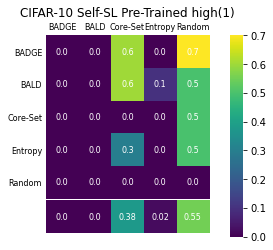

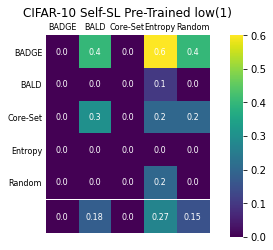

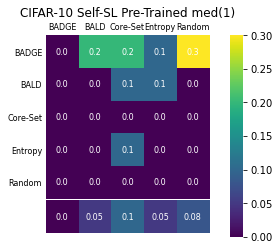

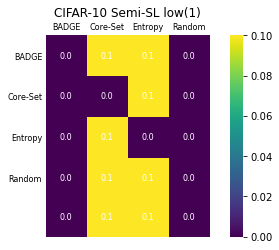

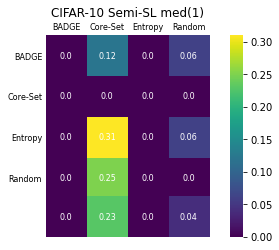

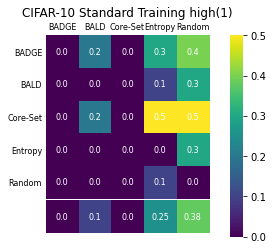

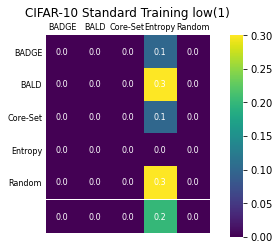

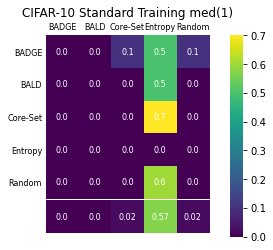

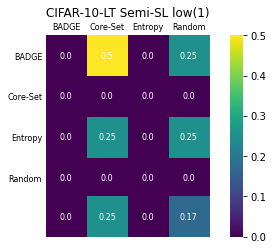

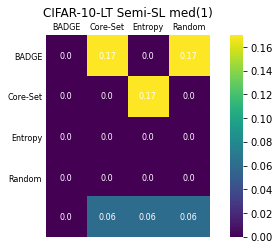

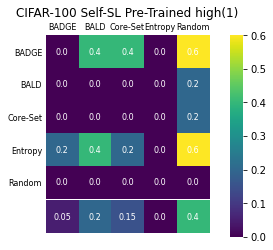

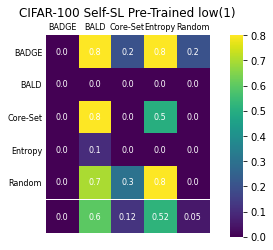

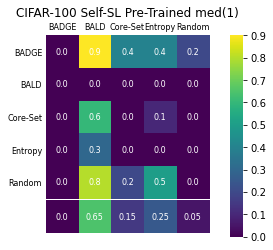

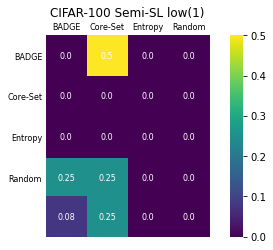

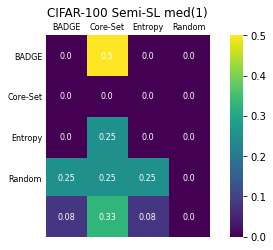

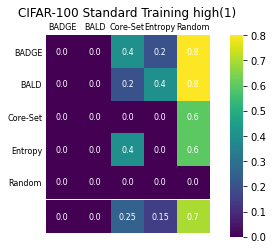

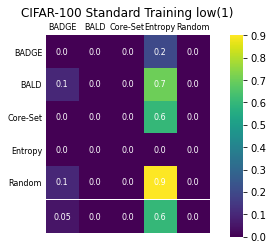

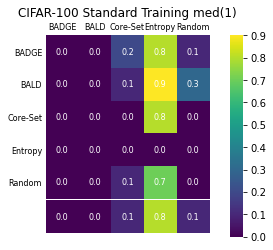

In [17]:
for i, (setting, matrix) in enumerate(zip(settings, matrices)):
    plot_setting = " ".join(setting)
    plot_pairwise_matrix(matrix, plot_setting)


## Plots for Label Regimes and Trainings

('Self-SL Pre-Trained', 'high')
('Self-SL Pre-Trained', 'low')
('Self-SL Pre-Trained', 'med')
('Semi-SL', 'low')
('Semi-SL', 'med')
('Standard Training', 'high')
('Standard Training', 'low')
('Standard Training', 'med')


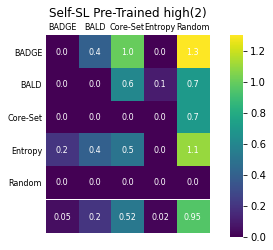

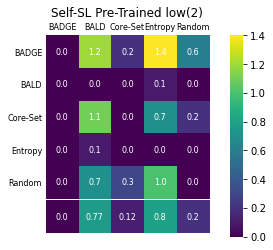

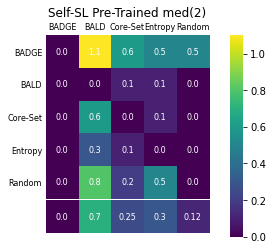

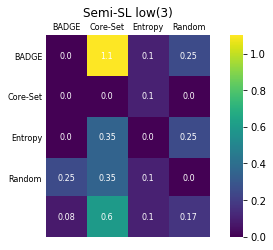

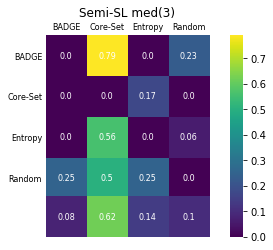

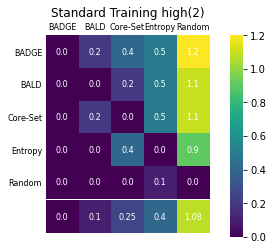

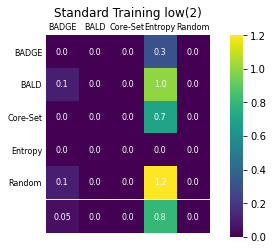

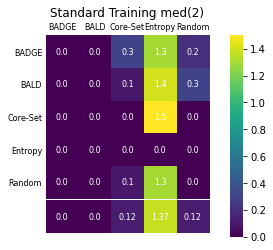

In [18]:
aggregate_list = [0]
aggregate_list.sort(reverse=True)
new_settings = dict()
for setting, matrix in zip(settings, matrices):
    new_setting = list(setting)
    for agg in aggregate_list:
        new_setting.pop(agg)
    new_setting = tuple(new_setting)
    if new_setting not in new_settings:
        new_settings[new_setting] = [matrix]
    else:
        new_settings[new_setting].append(matrix)
for setting_name, matrix_setting in new_settings.items():
    print(setting_name)
    keys = [key for key in matrix_setting[0].keys()]
    final_matrix = {}
    for k1 in keys:
        final_matrix[k1] = {}
        for k2 in keys:
            final_matrix[k1][k2]= sum([matrix[k1][k2] for matrix in matrix_setting])
    max_poss_ent = len(matrix_setting)
    plot_pairwise_matrix(final_matrix, " ".join(setting_name), max_poss_ent=max_poss_ent, show=False)

## Plots for Trainings

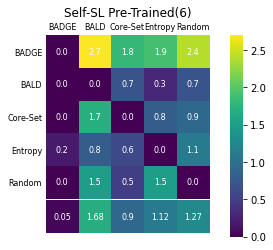

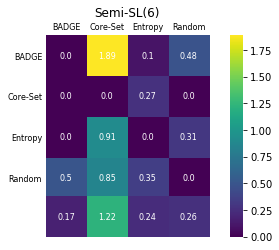

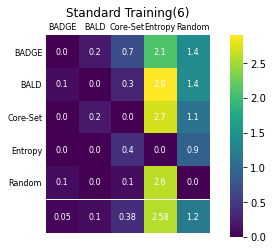

In [19]:
aggregate_list = [0,2]
aggregate_list.sort(reverse=True)
new_settings = dict()
for setting, matrix in zip(settings, matrices):
    new_setting = list(setting)
    for agg in aggregate_list:
        new_setting.pop(agg)
    new_setting = tuple(new_setting)
    if new_setting not in new_settings:
        new_settings[new_setting] = [matrix]
    else:
        new_settings[new_setting].append(matrix)
for setting_name, matrix_setting in new_settings.items():
    keys = [key for key in matrix_setting[0].keys()]
    final_matrix = {}
    for k1 in keys:
        final_matrix[k1] = {}
        for k2 in keys:
            final_matrix[k1][k2]= sum([matrix[k1][k2] for matrix in matrix_setting])
    max_poss_ent = len(matrix_setting)
    plot_pairwise_matrix(final_matrix, " ".join(setting_name), max_poss_ent=max_poss_ent)